In [2]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

# Predicting the quality of white wine 

knitr::include_graphics("img/rmarkdown_hex.png")
```

# Introduction

## Background

Wine quality is a complex interplay of several factors that come together. The investigation to the various elements that contribute to wine quality is important to meets consumer preferences and innovations in wine making.

## Question

Based on the character traits of the wine, what will be the quality of the given white wine?

The predictors include pH level, residual sugar (g/dm^3), chlorides (g(sodium chloride)/dm3), density (g/cm^3), and citric acid (g/dm3).

## The Dataset 

The dataset will be using the is related to white variants of the Portuguese "Vinho Verde" wine  https://archive.ics.uci.edu/dataset/186/wine+quality.

The original dataset contains both red wine and white wine. We will focus on white wine in our study.

# Preliminary Exploratory Data Analysis

In [3]:
download.file("https://archive.ics.uci.edu/static/public/186/wine+quality.zip", "wine.zip")

In [4]:
unzip("wine.zip", "winequality-white.csv")

In [5]:
white_wine_data <- read_csv2("winequality-white.csv") |>
    mutate_if(is.character, as.numeric) |>
    mutate(quality = as.factor(quality))
white_wine_data 

ℹ Using "','" as decimal and "'.'" as grouping mark. Use `read_delim()` for more control.

Rows: 4898 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
chr (6): volatile acidity, citric acid, residual sugar, chlorides, density, ...
dbl (1): quality
num (5): fixed acidity, free sulfur dioxide, total sulfur dioxide, pH, alcohol

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
7,0.27,0.36,20.7,0.045,45,170,1.0010,3,0.45,88,6
63,0.30,0.34,1.6,0.049,14,132,0.9940,33,0.49,95,6
81,0.28,0.40,6.9,0.050,30,97,0.9951,326,0.44,101,6
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
65,0.24,0.19,1.2,0.041,30,111,0.99254,299,0.46,94,6
55,0.29,0.30,1.1,0.022,20,110,0.98869,334,0.38,128,7
6,0.21,0.38,0.8,0.020,22,98,0.98941,326,0.32,118,6


In [6]:
set.seed(2023)
wine_data_split <- white_wine_data |>
    initial_split(prop = 0.75, strata = quality)

wine_data_train <- training(wine_data_split)
wine_data_test <- testing(wine_data_split)

In [7]:
summary(wine_data_train)

 fixed acidity    volatile acidity  citric acid     residual sugar 
 Min.   :  5.00   Min.   :0.0800   Min.   :0.0000   Min.   : 0.60  
 1st Qu.: 61.00   1st Qu.:0.2100   1st Qu.:0.2700   1st Qu.: 1.70  
 Median : 67.00   Median :0.2600   Median :0.3200   Median : 5.10  
 Mean   : 62.24   Mean   :0.2769   Mean   :0.3343   Mean   : 6.33  
 3rd Qu.: 73.00   3rd Qu.:0.3200   3rd Qu.:0.3800   3rd Qu.: 9.90  
 Max.   :715.00   Max.   :1.1000   Max.   :1.6600   Max.   :26.05  
                                                                   
   chlorides       free sulfur dioxide total sulfur dioxide    density      
 Min.   :0.00900   Min.   :   3.00     Min.   :   9.0       Min.   :0.9871  
 1st Qu.:0.03600   1st Qu.:  23.00     1st Qu.: 107.0       1st Qu.:0.9917  
 Median :0.04300   Median :  34.00     Median : 134.0       Median :0.9937  
 Mean   :0.04548   Mean   :  41.24     Mean   : 148.7       Mean   :0.9940  
 3rd Qu.:0.05000   3rd Qu.:  46.00     3rd Qu.: 167.0       3rd Qu.:0.9

In [8]:
wine_data_train |> 
group_by(quality) |>
summarise(across(`fixed acidity`: `alcohol`, mean, na.rm = TRUE))

Warning message:
“There was 1 warning in `summarise()`.
ℹ In argument: `across(`fixed acidity`:alcohol, mean, na.rm = TRUE)`.
ℹ In group 1: `quality = 3`.
Caused by warning:
! The `...` argument of `across()` is deprecated as of dplyr 1.1.0.
Supply arguments directly to `.fns` through an anonymous function instead.

  # Previously
  across(a:b, mean, na.rm = TRUE)

  # Now
  across(a:b, \(x) mean(x, na.rm = TRUE))”


quality,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3,76.64286,0.3439286,0.3350000,6.075000,0.05714286,251.42857,605.8571,0.9948414,297.7857,0.4885714,8.307143e+01
4,64.01639,0.3814754,0.3060656,4.561885,0.04870492,33.92623,124.2705,0.9942252,290.2459,0.4679508,9.736066e+01
5,65.16239,0.3009817,0.3409908,7.284358,0.05172202,40.01101,155.8688,0.9952469,284.6404,0.4834771,3.947095e+12
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
7,60.20030,0.2606829,0.3238695,5.033308,0.03795599,43.61457,129.1487,0.9923936,286.8968,0.5059939,8.824482e+11
8,57.56818,0.2730303,0.3292424,5.870455,0.03928788,35.38636,196.9848,0.9924814,300.1894,0.4801515,1.073636e+02
9,70.00000,0.3050000,0.3700000,2.500000,0.02550000,34.75000,114.0000,0.9900750,333.5000,0.4675000,1.262500e+02


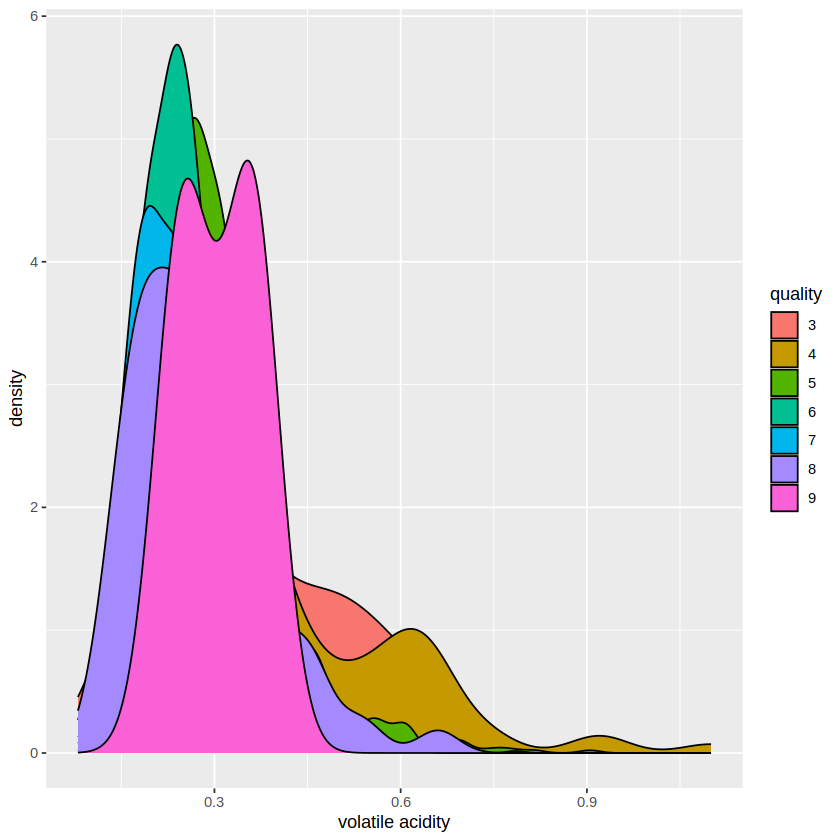

In [9]:
plot_2 <- wine_data_train |>
    ggplot(aes(x = `volatile acidity`, fill = quality),) +
    geom_density()
plot_2

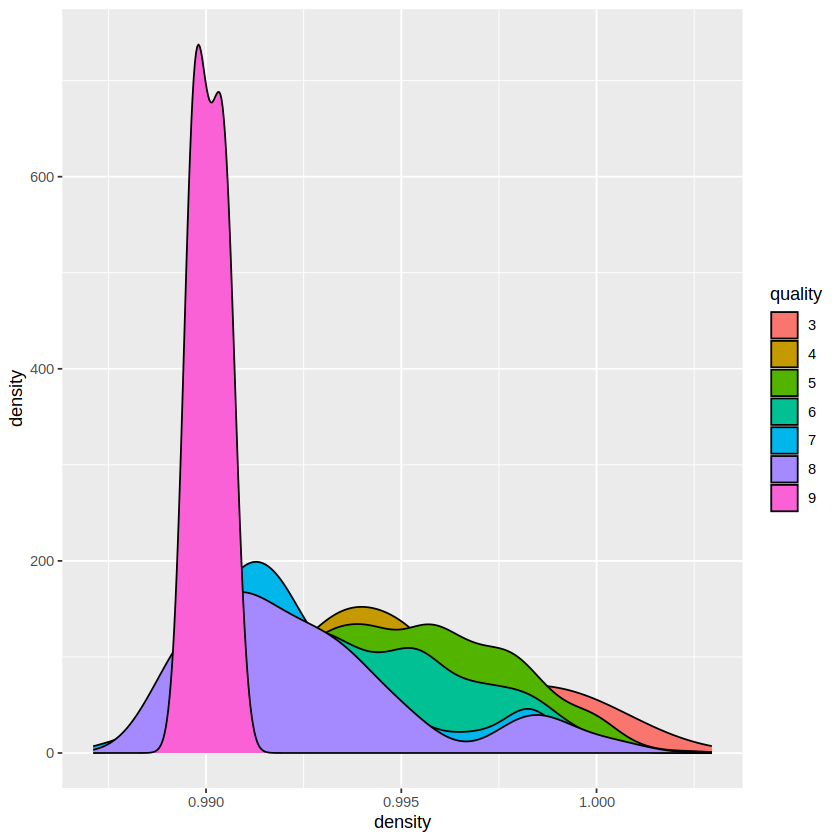

In [10]:
plot_1 <- wine_data_train |>
    ggplot(aes(x = `density`, fill = quality),) +
    geom_density() 
plot_1

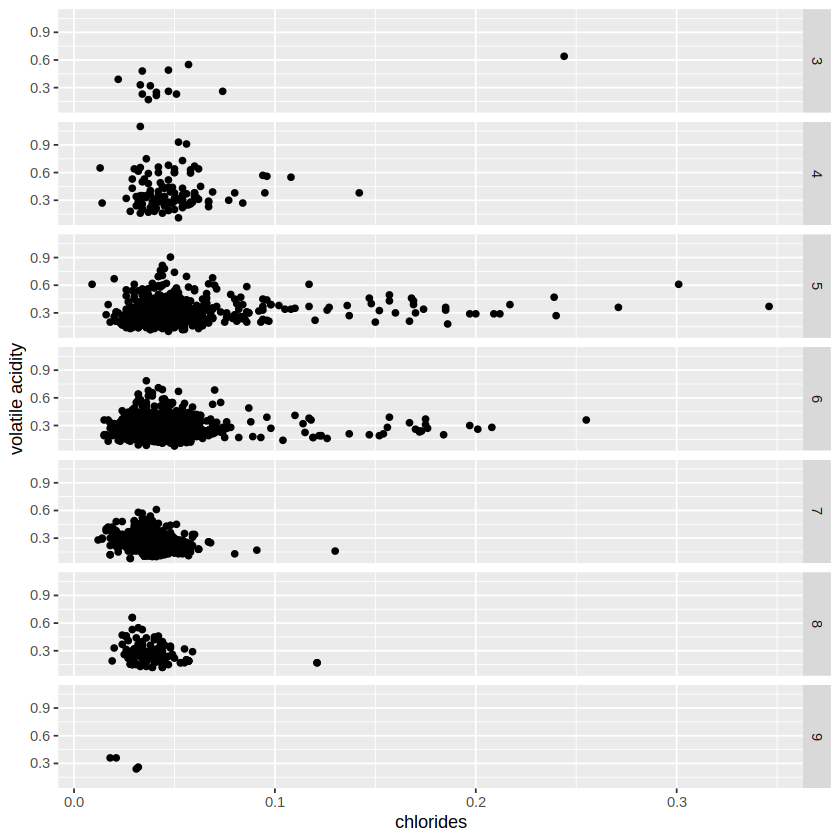

In [11]:
plot_3 <- wine_data_train |>
    ggplot(aes(x = `chlorides`, y = `volatile acidity` )) +
    facet_grid(rows = vars(quality)) +
    geom_point()
plot_3

In [12]:
wine_data_select <- white_wine_data |>
    select(quality, `volatile acidity`, `chlorides`, `density`, `pH`, `sulphates` )

wine_data_select

quality,volatile acidity,chlorides,density,pH,sulphates
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
6,0.27,0.045,1.0010,3,0.45
6,0.30,0.049,0.9940,33,0.49
6,0.28,0.050,0.9951,326,0.44
⋮,⋮,⋮,⋮,⋮,⋮
6,0.24,0.041,0.99254,299,0.46
7,0.29,0.022,0.98869,334,0.38
6,0.21,0.020,0.98941,326,0.32


# Expected outcomes and significance

 * We expect to find the quality of a specific white wine using the predictors “volatile acidity”, “pH”, “density” and “sulphates”.

 * It could help producers know which aspect of wine making to make improvements on to subsequently increase their product quality and attract more wholesale buyers.

 * This study may lead to questions about the nuanced interactions between these predictors and other influential factors in wine quality, prompting exploration into more refined or additional variables that could further enhance predictions. Additionally, it could inspire investigations into specific techniques or alterations in winemaking processes aimed at optimizing these predictors and their collective impact on wine quality.
